In [1]:
import sys
import os
import urllib
import time

from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np

import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt

from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline

W0901 09:04:18.959433 140190800152384 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/slim-0.1-py3.6.egg/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0901 09:04:19.004178 140190800152384 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/slim-0.1-py3.6.egg/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [2]:
import ipywidgets as widgets

In [3]:
MODELS = ['ssd_mobilenet_v1_coco', 'ssd_mobilenet_v1_0.75_depth_coco', 'ssd_mobilenet_v1_fpn_coco',
          'ssd_mobilenet_v2_coco', 'ssdlite_mobilenet_v2_coco', 'ssd_inception_v2_coco', 'ssd_resnet_50_fpn_coco',
          'faster_rcnn_inception_v2_coco', 'faster_rcnn_resnet50_coco', 'faster_rcnn_resnet101_coco',
          'faster_rcnn_inception_resnet_v2_atrous_coco', 'faster_rcnn_nas',
          'mask_rcnn_resnet50_atrous_coco', 'mask_rcnn_resnet101_atrous_coco', 'mask_rcnn_inception_resnet_v2_atrous_coco']

w = widgets.Dropdown(options=MODELS,
                 value='ssd_mobilenet_v1_coco',
                 description='model:',
                 disabled=False,)
display(w)

Dropdown(description='model:', options=('ssd_mobilenet_v1_coco', 'ssd_mobilenet_v1_0.75_depth_coco', 'ssd_mobi…

In [4]:
MODEL = w.value
DATA_DIR = './data/'
CONFIG_FILE = MODEL + '.config'   # ./data/ssd_inception_v2_coco.config 
CHECKPOINT_FILE = 'model.ckpt'    # ./data/ssd_inception_v2_coco/model.ckpt
IMAGE_PATH = './data/huskies.jpg'

### Download the pretrained model

Download the model configuration file and checkpoint containing pretrained weights by using the following command.  

For improved performance, increase the non-max suppression score threshold in the downloaded config file from 1e-8 to something greater, like 0.1.

In [5]:
config_path, checkpoint_path = download_detection_model(MODEL, 'data')

### Build the frozen graph

In [6]:
frozen_graph, input_names, output_names = build_detection_graph(
    config=config_path,
    checkpoint=checkpoint_path,
    score_threshold=0.3,
    batch_size=1
)

W0901 09:08:58.797062 140190800152384 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/tf_trt_models-0.0-py3.6.egg/tf_trt_models/detection.py:179: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0901 09:08:58.798357 140190800152384 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/tf_trt_models-0.0-py3.6.egg/tf_trt_models/detection.py:183: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0901 09:08:58.974009 140190800152384 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/object_detection-0.1-py3.6.egg/object_detection/exporter.py:381: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0901 09:08:58.975014 140190800152384 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/object_detection-0.1-py3.6.egg/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.com

### Optimize the model with TensorRT

In [7]:
print(output_names)

['detection_boxes', 'detection_classes', 'detection_scores', 'num_detections']


In [8]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

In [9]:
save_path = os.path.join('.', 'model')
if tf.gfile.Exists(save_path) == False:
    tf.gfile.MkDir(save_path)

In [10]:
save_file_path = os.path.join(save_path,  MODEL + '_trt_fp16.pb')
with open(save_file_path, 'wb') as f:
    f.write(trt_graph.SerializeToString())

### Create session and load graph

In [11]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

### Load and Preprocess Image

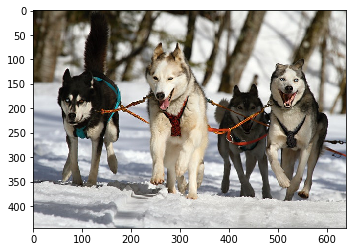

In [12]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((300, 300)))
image = np.array(image)

### Run network on Image

In [13]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_resized[None, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = num_detections[0]

### Display Results

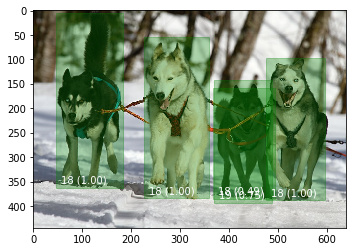

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(num_detections.astype('int32')):
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()

### Benchmark

In [15]:
num_samples = 50

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.644130 seconds


### Close session to release resources

In [16]:
tf_sess.close()